In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd 
from sklearn.utils import shuffle

%matplotlib inline

In [0]:
# Number of layers in the network
NUM_LAYERS = 2
# Nimber of features of the input data
FEATURES_NUM_X = 7
# Number of classes to classify
CLASSES_NUMBER = 2
# Mini batch size
MINI_BATCH_SIZE = 32

# layers is a vector with the length corrisponding to the number of layers we want
# in the network and the scalar at each position represents the number of neurons
layers = [8, CLASSES_NUMBER]

In [0]:
def map_data(data):
    """ 
    Map the string values in the dataset
    
    Arguments:
    data: panda dataset

    Returns:
    data: panda dataset
    """

    # Map every string in the dataset, we can only have numbers
    sex_class_mapping = {label: idx for idx, label in enumerate(np.unique(data["Sex"]))}
    # The final astype ensures the object is treated like a string
    embarked_class_mapping = {label: idx for idx, label in enumerate(np.unique(data["Embarked"].astype(str)))}
    data["Sex"] = data["Sex"].map(sex_class_mapping)
    data["Embarked"] = data["Embarked"].map(embarked_class_mapping)
    data['Fare'] = data['Fare'].astype(int)

    return data

In [0]:
def train_test_split(X, y, test_size=0.2, random_state=0):
  """ 
  Split arrays or matrices into random train and test subsets
    
  Arguments:
  X: panda feature dataset
  y: panda feature dataset
  test_size: size of the returning test set
  random_state: random seed to shuffle data 

  Returns:
  X_train: train subset of the original dataset
  y_train: train label subset of the original dataset
  X_test: test subset of the original dataset
  y_train: test label subset of the original dataset
  """
  X, y = shuffle(X, y, random_state= random_state)
  part_to_take = int(len(X) * 0.2)

  X_train = X.head(len(X) - part_to_take)
  Y_train = y.head(len(X) - part_to_take)
  X_test = X.tail(part_to_take)
  Y_test = y.tail(part_to_take)

  return X_train, X_test, Y_train, Y_test

In [0]:
def manage_nan_values(data):
  """ 
  Replace the NaN values of the dataset with the mean of the column
    
  Arguments:
  data: panda dataset

  Returns:
  data: panda dataset
  """
    return data.where(pd.notna(data), data.mean(), axis='columns')

In [0]:
def split_batches(X, y, batch_size, random_state = 0):
  """ 
  Split dataset in mini batches
    
  Arguments:
  X: panda feature dataset
  y: panda feature dataset
  batch_size: size of each batch
  random_state: random seed to shuffle data 

  Returns:
  mini_batches: array of tuples containing (mini_x, mini_y)
  """
  X, y = shuffle(X, y, random_state=random_state)
  num_of_batches = int(len(X) / batch_size)
  dec_part = len(X) % batch_size
  mini_batches = [] 

  for i in range(0, num_of_batches):
    from_index = i*batch_size
    to_index = from_index+batch_size
    mini_batches.append((X.iloc[from_index:to_index], y.iloc[from_index:to_index]))

  mini_batches.append((X.iloc[batch_size*num_of_batches:], y.iloc[batch_size*num_of_batches:]))

  return mini_batches

In [0]:
 def one_hot_encoding(indices):
  """ 
  One hot encoding of the label dataset
    
  Arguments:
  indices: panda label dataset

  Returns:
  one hot encoding of the input dataset
  """

  return pd.get_dummies(indices)

In [0]:
def create_placeholders(x_size, y_size):

    """ 
    Create the placeholders for the session
    
    Arguments:
    x_size: number of features of the input data
    y_size: number of classes of labels

    Returns:
    X: placeholder for the input data
    Y: placeholder for the output data
    """

    X = tf.placeholder(tf.float32, [x_size, None], name="X")
    Y = tf.placeholder(tf.float32, [y_size, None], name="Y")
    
    return X, Y

In [0]:
def initialize_parameters():
    
    """ 
    Initialize the params for the network
    
    Arguments: --

    Returns:
    parameters: a key value object that stores the weights and the bias
     """

    parameters = {}
    for i in range(0, NUM_LAYERS):
      if i==0:
        parameters["W1"] = tf.get_variable("W1", [layers[i], FEATURES_NUM_X], initializer = tf.contrib.layers.xavier_initializer(seed=1))
      else:
        parameters["W"+str(i+1)] = tf.get_variable("W"+str(i+1), [layers[i], layers[i-1]], initializer = tf.contrib.layers.xavier_initializer(seed=1))
      parameters["b"+str(i+1)] = tf.get_variable("b"+str(i+1), [layers[i], 1], initializer = tf.zeros_initializer())
    
    return parameters

In [0]:
def forward_propagation(X, parameters):

    """ 
    Implements forward propagation, it uses the same activation function for the whole network
    
    Arguments: 
    X: input data
    parameters: key value object containing weigths and params

    Returns:
    Z["Z" + (NUM_LAYERS)]: last computed weight computation
     """

    Z = {}
    A = {}

    A["A0"] = X
    for i in range(0, NUM_LAYERS):
      Z["Z"+ str(i+1)] = tf.add(tf.matmul(parameters["W"+str(i+1)], A["A"+str(i)]), parameters["b"+ str(i+1)])
      if (i+1) != NUM_LAYERS:
        A["A"+ str(i+1)] = tf.nn.relu(Z["Z"+ str(i+1)])
    
    return Z["Z" + str(NUM_LAYERS)]

In [0]:
def compute_cost(least_z, Y):
    """
    Computes the cost
    
    Arguments:
    least_z: least computed z of the network
    Y -- ground truth
    
    Returns:
    cost: tensor of the cost function
    """
    
    logits = tf.transpose(least_z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1000, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()       
    m = X_train.shape[0]
    n_y = CLASSES_NUMBER
    costs = []
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(FEATURES_NUM_X, CLASSES_NUMBER)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    least_z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(least_z, Y)
    
    # Backpropagation
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = split_batches(X_train, Y_train, minibatch_size, epoch)


            for minibatch in minibatches:


                (minibatch_X, minibatch_Y) = minibatch
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X.T, Y: minibatch_Y.T})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True:
              if epoch % 100 == 0:
                  print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
              if epoch % 5 == 0:
                  costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(least_z), tf.argmax(Y))
          

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

   

        print ("Train Accuracy:", accuracy.eval({X: X_train.T, Y: y_train.T}))
        print ("Test Accuracy:", accuracy.eval({X: X_test.T, Y: y_test.T}))
        
        return parameters

In [0]:
data = pd.read_csv("data/train.csv") 

y = data.Survived
X = data.drop(["Survived", "PassengerId", "Name", "Cabin", "Ticket"], axis=1)
X = map_data(X)
X = manage_nan_values(X)

y = one_hot_encoding(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03)

Cost after epoch 0: 1.267201
Cost after epoch 100: 0.466646
Cost after epoch 200: 0.449542
Cost after epoch 300: 0.443506
Cost after epoch 400: 0.443924
Cost after epoch 500: 0.445774
Cost after epoch 600: 0.428326
Cost after epoch 700: 0.427163
Cost after epoch 800: 0.434086
Cost after epoch 900: 0.428610


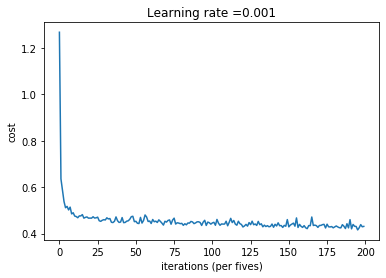

Parameters have been trained!
Train Accuracy: 0.8134642
Test Accuracy: 0.78651685


In [0]:
parameters = model(X_train, y_train, X_test, y_test, learning_rate = 0.001, minibatch_size=MINI_BATCH_SIZE)